In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from mnist import MNIST
from matplotlib import pyplot
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
from torch.utils.data import Dataset, TensorDataset, DataLoader

In [3]:
import matplotlib.pyplot as plt

In [4]:
import torchvision.datasets as datasets

In [5]:
from sklearn.metrics import roc_auc_score

In [6]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)

In [7]:
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

In [8]:
# !pip install python-mnist

In [9]:
len(mnist_trainset)

60000

In [10]:
len(mnist_testset)

10000

In [11]:
len(mnist_trainset.data), len(mnist_trainset.targets)

(60000, 60000)

Train: X=torch.Size([60000, 28, 28]), y=torch.Size([60000])
Test: X=torch.Size([10000, 28, 28]), y=torch.Size([10000])


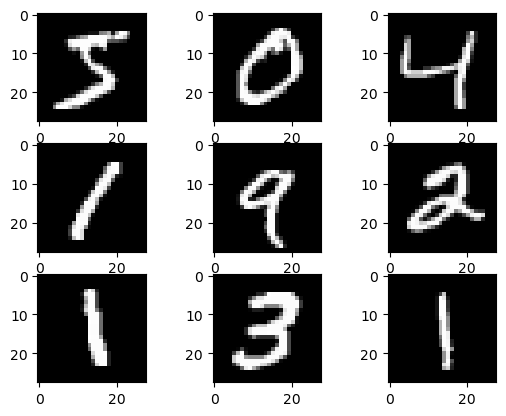

In [12]:
(trainX, trainy) = mnist_trainset.data, mnist_trainset.targets

(testX, testy) = mnist_testset.data, mnist_testset.targets

print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
	pyplot.imshow(trainX[i], cmap=pyplot.get_cmap('gray'))

# show the figure
pyplot.show()

In [13]:
for i in range(10):
  count_train = np.where(trainy == i)[0]
  count_test = np.where(testy == i)[0]

  print("Label %d - train: %.4f - test: %.4f" %(i, count_train.shape[0] / float(trainy.shape[0]), count_test.shape[0] / float(testy.shape[0]) ))

Label 0 - train: 0.0987 - test: 0.0980
Label 1 - train: 0.1124 - test: 0.1135
Label 2 - train: 0.0993 - test: 0.1032
Label 3 - train: 0.1022 - test: 0.1010
Label 4 - train: 0.0974 - test: 0.0982
Label 5 - train: 0.0903 - test: 0.0892
Label 6 - train: 0.0986 - test: 0.0958
Label 7 - train: 0.1044 - test: 0.1028
Label 8 - train: 0.0975 - test: 0.0974
Label 9 - train: 0.0992 - test: 0.1009


In [14]:
# prepare data for training
trainX.shape, trainy.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]))

In [15]:
trainX.shape

torch.Size([60000, 28, 28])

In [16]:
torch.mean(trainX.to(torch.float))

tensor(33.3184)

In [17]:
torch.std(trainX.to(torch.float))

tensor(78.5675)

In [18]:
train_x_norm = (trainX - torch.mean(trainX.to(torch.float))) / torch.std(trainX.to(torch.float))

In [19]:
trainy

tensor([5, 0, 4,  ..., 5, 6, 8])

In [20]:
train_ds = TensorDataset(train_x_norm, trainy)
torch.manual_seed(1234)
batch_size = 100
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [21]:
class DNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(DNN, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.fc2 = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
    x = self.fc1(x)
    x = nn.Sigmoid()(x)
    x = self.fc2(x)
    # x = nn.Softmax(dim=1)(x)
    return x

In [22]:
input_size = 28*28
hidden_size = 100
num_classes = 10
learning_rate = 0.001
num_epochs = 20

model = DNN(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()


In [23]:
loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs

In [24]:
i = 1
for epoch in range(num_epochs):
    print(i)
    for x_batch, y_batch in train_dl.dataset:
        pred = model(torch.flatten(x_batch))
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist[epoch] += loss.item()*y_batch.item()
        is_correct = (torch.argmax(pred) == y_batch).float()
        accuracy_hist[epoch] += is_correct.sum()
    accuracy_hist[epoch] /= len(train_dl.dataset)
    loss_hist[epoch] /= len(train_dl.dataset)
    i += 1

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


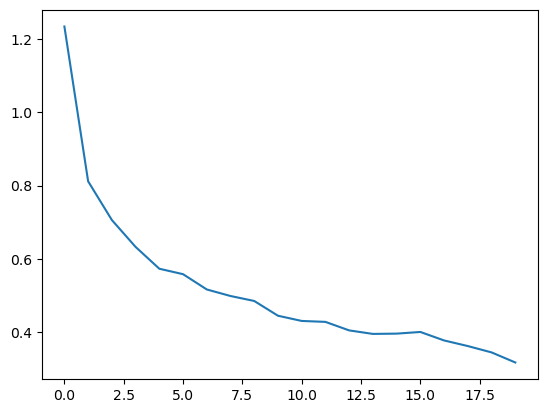

In [25]:
plt.plot(loss_hist)

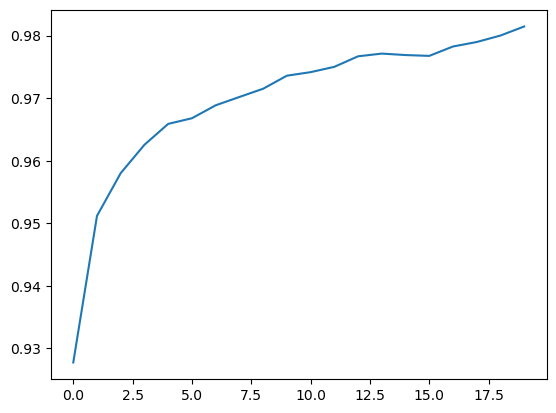

In [26]:
plt.plot(accuracy_hist)

In [27]:
accuracy_hist[-1].item()

0.9814500212669373

In [28]:
#Report:
#precision
#recall
#ROC curve
#confusion matrix

In [29]:
testX = testX.to(torch.float)

In [30]:
X_test_norm = (testX - torch.mean(testX)) / torch.std(testX)

In [31]:
X_test_norm.shape

torch.Size([10000, 28, 28])

In [32]:
# X_test_norm = torch.transpose(X_test_norm, 0, 2)

In [33]:
X_test_norm.shape

torch.Size([10000, 28, 28])

In [34]:
pred_test = model(torch.flatten(X_test_norm, start_dim=1, end_dim=2))

In [35]:
pred_class_test = torch.argmax(pred_test, dim=1)

In [36]:
correct = (pred_class_test == testy).float()

In [37]:
precision_by_class = [0] * num_classes
recall_by_class = [0] * num_classes
auroc_by_class = [0] * num_classes
confusion_matrix = [[0]*num_classes for i in range(num_classes)]

In [38]:
#need to confirm
for i in range(num_classes):
    
    p_index = (pred_class_test == i)
    
    precision_by_class[i] =  (correct[p_index].sum() / sum(p_index)).item()
    
    r_index = (testy == i)
    recall_by_class[i] = (correct[r_index].sum() / len(r_index)).item()

    pred_i = np.zeros(pred_test.shape[0])    
    pred_i[p_index] = 1
    
    testy_i = np.zeros(testy.shape[0])
    testy_i[r_index] = 1
    auroc_by_class[i] = roc_auc_score(testy_i, pred_i)

    for j in range(num_classes):
        confusion_matrix[i][j] = (testy[p_index] == j).sum().item()


In [39]:
print('precision by classes')
print(precision_by_class)

precision by classes
[0.9767441749572754, 0.9757785201072693, 0.9626794457435608, 0.9544131755828857, 0.9694501161575317, 0.9343379735946655, 0.9870410561561584, 0.9760239720344543, 0.978723406791687, 0.9640359878540039]


In [40]:
print('recall by classes')
print(recall_by_class)

recall by classes
[0.0966000035405159, 0.1128000020980835, 0.1005999967455864, 0.09839999675750732, 0.09520000219345093, 0.0868000015616417, 0.09139999747276306, 0.09769999980926514, 0.09200000017881393, 0.09650000184774399]


In [41]:
print('auroc by class')
print(auroc_by_class)

auroc by class
[0.9915821982895153, 0.9953370553406332, 0.9852287029161393, 0.9845146972984284, 0.9830617109298037, 0.9831983807661328, 0.9763719205987923, 0.9738570581020762, 0.9711713502994543, 0.9761942318929434]


In [42]:
print('confusion matrix')
for i in range(num_classes):
    print(confusion_matrix[i])

confusion matrix
[966, 0, 2, 0, 0, 2, 10, 3, 5, 1]
[0, 1128, 5, 0, 2, 1, 3, 9, 2, 6]
[2, 1, 1006, 5, 5, 1, 4, 11, 8, 2]
[0, 3, 4, 984, 2, 11, 1, 7, 13, 6]
[0, 0, 2, 3, 952, 1, 3, 6, 4, 11]
[6, 1, 5, 6, 2, 868, 19, 0, 11, 11]
[2, 0, 1, 0, 3, 2, 914, 1, 2, 1]
[2, 0, 4, 6, 2, 1, 0, 977, 5, 4]
[2, 2, 2, 1, 1, 2, 4, 4, 920, 2]
[0, 0, 1, 5, 13, 3, 0, 10, 4, 965]


In [43]:
#CNN

In [450]:
torch.manual_seed(123)
batch_size = 64

In [636]:
train_dl = DataLoader(list(zip(train_x_norm,trainy)), shuffle=True, batch_size=64,drop_last=True)

In [568]:
x = torch.ones(64,1,28,28)

In [570]:
model = torch.nn.Sequential()

In [572]:
model.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=32, kernel_size = 5, padding = 2))

In [574]:
model(x).shape

torch.Size([64, 32, 28, 28])

In [576]:
model.add_module('relu1', nn.ReLU())

In [578]:
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))

In [580]:
model(x).shape

torch.Size([64, 32, 14, 14])

In [582]:
model.add_module('conv2', nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 5, padding = 2))

In [584]:
model(x).shape

torch.Size([64, 64, 14, 14])

In [586]:
model.add_module('relu2', nn.ReLU())

In [588]:
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))

In [590]:
model(x).shape

torch.Size([64, 64, 7, 7])

In [592]:
model.add_module('flatten', nn.Flatten())

In [594]:
model(x).shape

torch.Size([64, 3136])

In [596]:
model.add_module('fc1', nn.Linear(3136, 1024))

In [598]:
model(x).shape

torch.Size([64, 1024])

In [600]:
model.add_module('relu3', nn.ReLU())

In [602]:
model.add_module('dropout', nn.Dropout(p=0.5))

In [604]:
model(x).shape

torch.Size([64, 1024])

In [606]:
model.add_module('fc2', nn.Linear(1024,10))

In [608]:
model(x).shape

torch.Size([64, 10])

In [610]:
loss_fn = nn.CrossEntropyLoss()

In [612]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [693]:
num_classes = 10
num_epochs = 10

In [716]:
precision_by_class = [0] * num_classes
recall_by_class = [0] * num_classes
auroc_by_class = [0] * num_classes
confusion_matrix = [[0]*num_classes for i in range(num_classes)]

In [714]:
loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs

In [620]:
for X_batch, y_batch in train_dl:
    print(torch.unsqueeze(X_batch, 1).shape, y_batch.shape)
    break

torch.Size([64, 1, 28, 28]) torch.Size([64])


In [622]:
pred = model(torch.unsqueeze(X_batch, 1))

In [624]:
pred.shape

torch.Size([64, 10])

In [626]:
loss_fn(pred, y_batch)

tensor(2.2978, grad_fn=<NllLossBackward0>)

In [718]:
i = 1
for epoch in range(num_epochs):
    print(i)
    model.train()
    for x_batch, y_batch in train_dl:
        pred = model(torch.unsqueeze(X_batch, 1))
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist[epoch] += loss.item()*y_batch.size(0)
        is_correct = (torch.argmax(pred) == y_batch).float()
        accuracy_hist[epoch] += is_correct.sum()
    accuracy_hist[epoch] /= len(train_dl.dataset)
    loss_hist[epoch] /= len(train_dl.dataset)
    i += 1

1
2
3
4
5
6
7
8
9
10


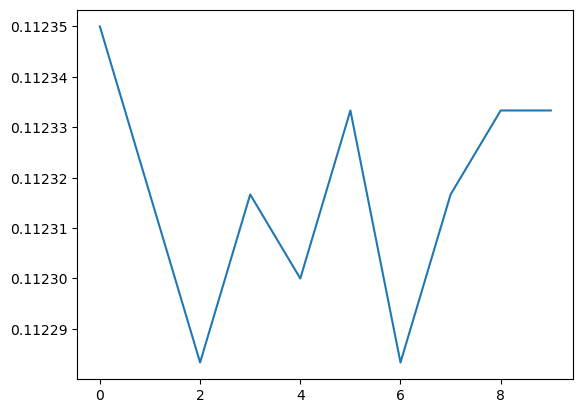

In [735]:
plt.plot(accuracy_hist)

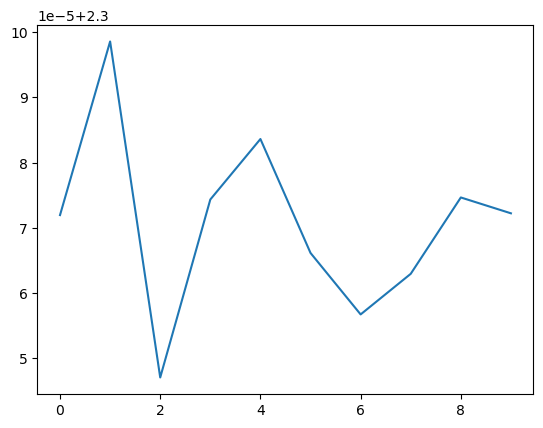

In [720]:
plt.plot(loss_hist)

In [721]:
X_test_norm.shape

torch.Size([10000, 28, 28])

In [722]:
pred_test = model(torch.unsqueeze(X_test_norm, 1))

In [723]:
pred_test.shape

torch.Size([10000, 10])

In [724]:
pred_test[10000-1,:]

tensor([-0.0215,  0.1177, -0.0050,  0.0153, -0.0268, -0.1160, -0.0264,  0.0505,
        -0.0330, -0.0037], grad_fn=<SliceBackward0>)

In [725]:
pred_class_test = torch.argmax(pred_test, dim=1)

In [726]:
correct = (pred_class_test == testy).float()

In [727]:
pred_class_test[1]

tensor(1)

In [728]:
precision_by_class = [0] * num_classes
recall_by_class = [0] * num_classes
auroc_by_class = [0] * num_classes
confusion_matrix = [[0]*num_classes for i in range(num_classes)]

In [729]:
#need to confirm
for i in range(num_classes):
    
    p_index = (pred_class_test == i)
    
    precision_by_class[i] =  (correct[p_index].sum() / sum(p_index)).item()
    
    r_index = (testy == i)
    recall_by_class[i] = (correct[r_index].sum() / len(r_index)).item()

    pred_i = np.zeros(pred_test.shape[0])    
    pred_i[p_index] = 1
    
    testy_i = np.zeros(testy.shape[0])
    testy_i[r_index] = 1
    auroc_by_class[i] = roc_auc_score(testy_i, pred_i)

    for j in range(num_classes):
        confusion_matrix[i][j] = (testy[p_index] == j).sum().item()


In [730]:
print('precision by classes')
print(precision_by_class)

precision by classes
[nan, 0.11349999904632568, nan, nan, nan, nan, nan, nan, nan, nan]


In [731]:
print('recall by classes')
print(recall_by_class)

recall by classes
[0.0, 0.11349999904632568, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [732]:
print('auroc by class')
print(auroc_by_class)

auroc by class
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


In [733]:
print('confusion matrix')
for i in range(num_classes):
    print(confusion_matrix[i])

confusion matrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[980, 1135, 1032, 1010, 982, 892, 958, 1028, 974, 1009]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
